In [102]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np
from admm.agents import FedConsensus
from admm.servers import EventADMM
from admm.models import FCNet, CNN
from admm.utils import average_params
from admm.data import partition_data, split_dataset
import seaborn as sns
sns.set_theme()

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
cifar_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar_trainset = datasets.CIFAR10(
    root='./data/cifar10', train=True,
    download=True, transform=cifar_transform
)
cifar_testset = datasets.CIFAR10(
    root='./data/cifar10', train=False,
    download=False, transform=cifar_transform
)

mnist_transform = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)), transforms.Lambda(lambda x: torch.flatten(x))
])

mnist_trainset = datasets.MNIST(
    root='./data/mnist_data', train=True,
    download=True, transform=mnist_transform
)
mnist_testset = datasets.MNIST(
    root='./data/mnist_data', train=False,
    download=False, transform=mnist_transform
)

Files already downloaded and verified


In [104]:
train_dataset, val_dataset, _ = split_dataset(dataset=mnist_trainset, train_ratio=0.8, val_ratio=0.2)

trainsets = partition_data(
    num_clients=10,
    iid=True,
    balance=True,
    power_law=True,
    seed=42,
    trainset=train_dataset.dataset,
    labels_per_partition=10
)

for i, dataset in enumerate(trainsets):
    labels = np.zeros(10)
    loader = DataLoader(dataset, batch_size=1)
    for data, target in loader:
        labels[target.item()] += 1
    print(f'Dataset {i} distribution: {labels} - num_samples = {labels.sum()}')

labels = np.zeros(10)
loader = DataLoader(val_dataset, batch_size=1)
for data, target in loader:
    labels[target.item()] += 1
print(f'Validation dataset {i} distribution: {labels} - num_samples = {labels.sum()}')

oader = DataLoader(val_dataset, batch_size=10)
for data, target in loader:
    print(data.shape)
    break

Dataset 0 distribution: [526. 489. 563. 518. 551. 569. 534. 551. 577. 543.] - num_samples = 5421.0
Dataset 1 distribution: [544. 555. 535. 543. 538. 519. 567. 523. 566. 531.] - num_samples = 5421.0
Dataset 2 distribution: [493. 537. 549. 573. 544. 561. 551. 528. 537. 548.] - num_samples = 5421.0
Dataset 3 distribution: [554. 529. 549. 536. 554. 536. 508. 509. 573. 573.] - num_samples = 5421.0
Dataset 4 distribution: [571. 514. 565. 538. 530. 567. 530. 540. 533. 533.] - num_samples = 5421.0
Dataset 5 distribution: [536. 561. 562. 549. 527. 516. 553. 547. 520. 550.] - num_samples = 5421.0
Dataset 6 distribution: [567. 592. 504. 552. 558. 519. 526. 566. 529. 508.] - num_samples = 5421.0
Dataset 7 distribution: [562. 570. 527. 519. 559. 563. 561. 559. 490. 511.] - num_samples = 5421.0
Dataset 8 distribution: [544. 540. 509. 517. 535. 545. 565. 586. 539. 541.] - num_samples = 5421.0
Dataset 9 distribution: [524. 534. 558. 576. 525. 526. 526. 512. 557. 583.] - num_samples = 5421.0
Validation

In [105]:
batch_size = 32
train_loaders = [DataLoader(dataset, batch_size=batch_size, shuffle=True) for dataset in trainsets]
test_loader = DataLoader(mnist_testset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [106]:
rates = [0.005, 0.01, 0.02]
rho = 0.01
delta = 0
t_max = 150
# loaders = [digit_1_train_loader_fc, digit_2_train_loader_fc]
loaders = train_loaders
device = 'cpu'

acc_per_delta = np.zeros((len(rates), t_max))
rate_per_delta = np.zeros((len(rates), t_max))
loads = []
test_accs = []

print(f'N = {len(loaders)}')
for i, lr in enumerate(rates):
    
    agents = [
        FedConsensus(
            N=len(loaders),
            delta=delta,
            rho=rho,
            model=FCNet(in_channels=784, hidden1=200, hidden2=None, out_channels=10),
            loss=nn.CrossEntropyLoss(),
            train_loader=loader,
            classification=True,
            epochs=2,
            device=device,
            lr=lr
        ) for loader in loaders
    ]

    # Broadcast average to all agents and check if equal
    for agent in agents:
        agent.primal_avg = average_params([agent.model.parameters() for agent in agents])
    for param1, param2 in zip(agents[0].primal_avg, agents[1].primal_avg):
        if not torch.equal(param1, param2): raise ValueError("Averaged params aren't equal")

    # Run consensus algorithm
    server = EventADMM(clients=agents, t_max=t_max)
    server.spin(loader=val_loader)
    
    # For plotting purposes
    acc_per_delta[i,:] = server.val_accs
    rate_per_delta[i,:] = server.rates
    loads.append(server.comm)
    accs = server.validate(loader=test_loader)
    test_accs.append(sum(accs)/len(accs))

N = 10


Comm frequency: 1.000, agent 0: 0.89, agent 1: 0.90, agent 2: 0.89, agent 3: 0.90, agent 4: 0.90, agent 5: 0.89, agent 6: 0.90, agent 7: 0.90, agent 8: 0.89, agent 9: 0.90: 100%|██████████| 150/150 [16:37:38<00:00, 399.06s/it]    
Comm frequency: 1.000, agent 0: 0.89, agent 1: 0.88, agent 2: 0.87, agent 3: 0.88, agent 4: 0.89, agent 5: 0.88, agent 6: 0.89, agent 7: 0.87, agent 8: 0.88, agent 9: 0.87: 100%|██████████| 150/150 [1:46:10<00:00, 42.47s/it]  
Comm frequency: 1.000, agent 0: 0.86, agent 1: 0.85, agent 2: 0.86, agent 3: 0.81, agent 4: 0.87, agent 5: 0.86, agent 6: 0.86, agent 7: 0.86, agent 8: 0.84, agent 9: 0.86: 100%|██████████| 150/150 [49:51<00:00, 19.94s/it]


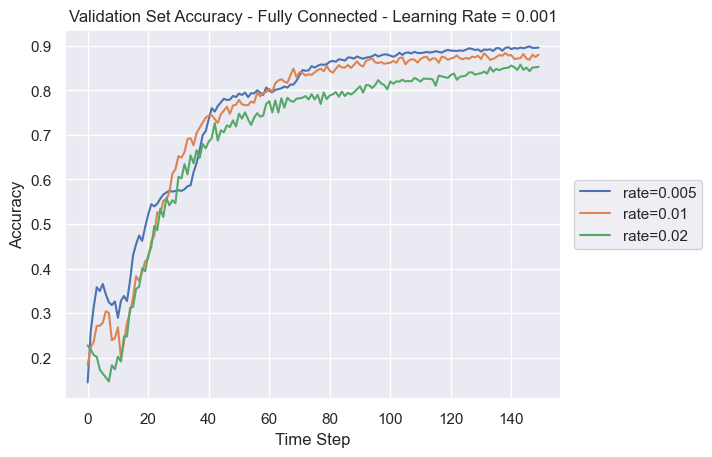

In [107]:
T = range(t_max)
# Plot accuracies
for acc, delta in zip(acc_per_delta, rates):
    plt.plot(T, acc, label=f'rate={delta}')
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
plt.xlabel('Time Step')
plt.ylabel('Accuracy')
plt.title('Validation Set Accuracy - Fully Connected - Learning Rate = 0.001')
plt.show()

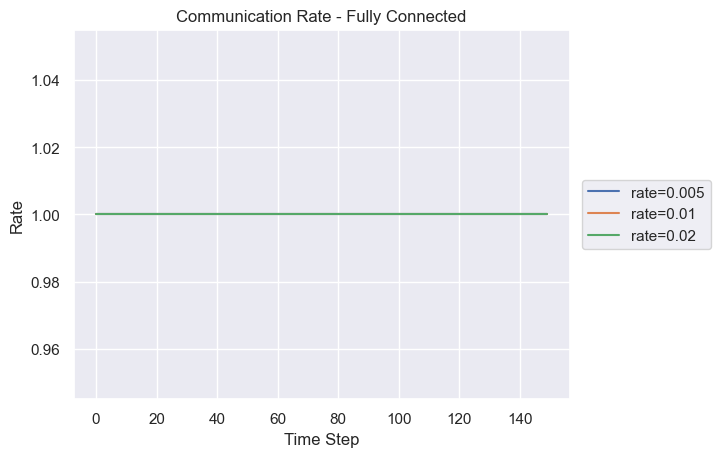

In [108]:
for rate, delta in zip(rate_per_delta, rates):
    plt.plot(T, rate, label=f'rate={delta}')
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
plt.xlabel('Time Step')
plt.ylabel('Rate')
plt.title('Communication Rate - Fully Connected')
plt.show()

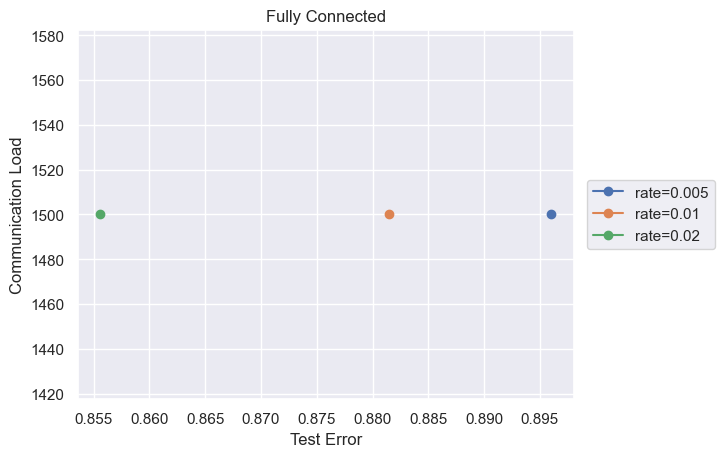

In [109]:
for load, acc, delta in zip(loads, test_accs, rates):
    plt.plot(acc, load, label=f'rate={delta}', marker='o')
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
plt.xlabel('Test Error')
plt.ylabel('Communication Load')
plt.title('Fully Connected')
plt.show()

In [110]:
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import ExponentialPartitioner, NaturalIdPartitioner, LinearPartitioner

nodes = 3
fds = FederatedDataset(dataset='cifar10', partitioners={'train': nodes, 'test': 1})
partitions = [fds.load_partition(node_id=node, split='train') for node in range(nodes)]

transforms = ToTensor()
def apply_transforms(batch):
  batch["img"] = [transforms(img) for img in batch["img"]]
  return batch

partitions_torch = [partition.with_transform(apply_transforms) for partition in partitions]

print('Training partitions')
for i, partition in enumerate(partitions):
    print(f'\nPartition {i}')
    b= []
    for i in range(10):
        a = [1 for label in partition['label'] if label == i]
        b.append(sum(a))
        a = []
    print(b)

print('\nTest partition\n')
partition = fds.load_partition(node_id=0, split='test')
b= []
for i in range(10):
    a = [1 for label in partition['label'] if label == i]
    b.append(sum(a))
    a = []
print(b)

Training partitions

Partition 0
[1705, 1605, 1682, 1628, 1669, 1683, 1674, 1692, 1643, 1686]

Partition 1
[1599, 1723, 1659, 1729, 1670, 1647, 1679, 1644, 1653, 1664]

Partition 2
[1696, 1672, 1659, 1643, 1661, 1670, 1647, 1664, 1704, 1650]

Test partition

[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
